In [5]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split



In [17]:
# ----------------------------
# Dataset and Transform
# ----------------------------
class LiverCancerUltrasoundDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("L")  # 转为灰度
        if self.transform:
            img = self.transform(img)
        return img, self.labels[idx]

def build_dataset(base_dir):
    dataset_dir = os.path.join(base_dir, '7272660')
    classes = {'Normal': 0, 'Benign': 1, 'Malignant': 2}
    image_paths = []
    labels = []

    for cls, label in classes.items():
        folder = os.path.join(dataset_dir, cls, cls, 'image')  # 关键改动在这里
        if not os.path.exists(folder):
            continue  
        for fname in os.listdir(folder):
            if fname.endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(folder, fname))
                labels.append(label)

    return image_paths, labels

base_dir = "ultrasound_liver_dataset"
image_paths, labels = build_dataset(base_dir)




train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42, stratify=labels
)


transform = transforms.Compose([
    transforms.Resize((224, 224)),  ###
    transforms.ToTensor(),          
])

train_dataset = LiverCancerUltrasoundDataset(train_paths, train_labels, transform)
val_dataset = LiverCancerUltrasoundDataset(val_paths, val_labels, transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


In [55]:
# ----------------------------
# Model Definition
# ----------------------------
class MCDropoutCNN(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.fc1 = nn.Linear(64 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, 3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# MC Dropout inference

def mc_predict(model, x, n_iter=20):
    model.train()  # Enable dropout
    preds = []
    with torch.no_grad():
        for _ in range(n_iter):
            logits = model(x)
            probs = F.softmax(logits, dim=1)
            preds.append(probs.unsqueeze(0))
    preds = torch.cat(preds, dim=0)
    mean = preds.mean(dim=0)
    std = preds.std(dim=0)
    return mean, std

In [57]:
# ----------------------------
# Training and Evaluation
# ----------------------------
def train_model(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return running_loss / total, correct / total

def evaluate_model(model, dataloader, device, n_iter=20):
    model.train()  # Required for MC Dropout
    all_preds, all_labels, uncertainty_vals = [], [], []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            mean_probs, std_probs = mc_predict(model, images, n_iter)
            preds = mean_probs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            uncertainty = std_probs.max(dim=1).values
            uncertainty_vals.extend(uncertainty.cpu().numpy())
    return np.array(all_preds), np.array(all_labels), np.array(uncertainty_vals)


In [ ]:
# ----------------------------
# Main Training Loop
# ----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MCDropoutCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

n_epochs = 10
for epoch in range(n_epochs):
    train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
    preds, labels, uncertainty = evaluate_model(model, val_loader, device)
    val_acc = (preds == labels).mean()
    print(f"Epoch {epoch+1}/{n_epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")



Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.55      0.63        20
           1       0.51      0.50      0.51        40
           2       0.83      0.89      0.86        87

    accuracy                           0.73       147
   macro avg       0.69      0.65      0.66       147
weighted avg       0.73      0.73      0.73       147



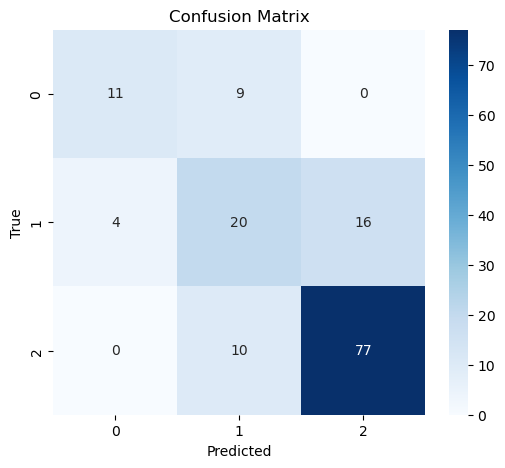

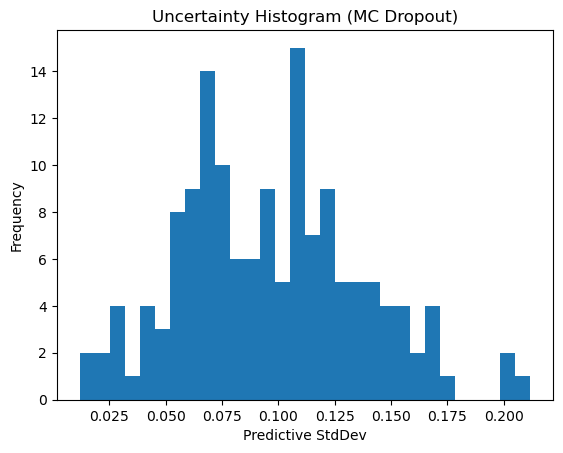

In [63]:
# ----------------------------
# Evaluation Reports
# ----------------------------
print("\nClassification Report:")
print(classification_report(labels, preds))

# Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(labels, preds), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Uncertainty Histogram
plt.figure()
plt.hist(uncertainty, bins=30)
plt.title("Uncertainty Histogram (MC Dropout)")
plt.xlabel("Predictive StdDev")
plt.ylabel("Frequency")
plt.show()

In [67]:
val_acc = (preds == labels).mean()
val_acc

0.7346938775510204

In [9]:
# Bayesian CNN using Blitz (Bayesian Linear Layers)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

from blitz.modules import BayesianLinear
from blitz.utils import variational_estimator
from sklearn.model_selection import train_test_split

In [11]:
# ----------------------------
# Bayesian CNN Model
# ----------------------------
@variational_estimator
class BayesianCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = BayesianLinear(64 * 56 * 56, 128)
        self.fc2 = BayesianLinear(128, 3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [13]:
# ----------------------------
# Training and Evaluation
# ----------------------------
def train_bayesian_model(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0
    for x_batch, y_batch in dataloader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        loss = model.sample_elbo(
            inputs=x_batch,
            labels=y_batch,
            criterion=nn.CrossEntropyLoss(),
            sample_nbr=3,
            complexity_cost_weight=1e-6
        )
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x_batch.size(0)
        with torch.no_grad():
            preds = model(x_batch).argmax(dim=1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)
    return total_loss / total, correct / total

def evaluate_bayesian_model(model, dataloader, device, n_iter=10):
    model.eval()
    preds_list = []
    labels_list = []
    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = torch.stack([model(x_batch) for _ in range(n_iter)], dim=0)  # [n_iter, B, C]
            mean_outputs = outputs.mean(dim=0)  # [B, C]
            preds = mean_outputs.argmax(dim=1)  # [B]
            preds_list.extend(preds.cpu().numpy())
            labels_list.extend(y_batch.cpu().numpy())
    return np.array(preds_list), np.array(labels_list)

In [ ]:
# ----------------------------
# Main Training Loop
# ----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BayesianCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

n_epochs = 10
for epoch in range(n_epochs):
    train_loss, train_acc = train_bayesian_model(model, train_loader, optimizer, device)
    preds, labels = evaluate_bayesian_model(model, val_loader, device)
    val_acc = (preds == labels).mean()
    print(f"Epoch {epoch+1}/{n_epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")


Epoch 1/10 | Train Loss: 120.2472 | Train Acc: 0.6054 | Val Acc: 0.6054
Epoch 2/10 | Train Loss: 116.2334 | Train Acc: 0.6956 | Val Acc: 0.6939
Epoch 3/10 | Train Loss: 114.0321 | Train Acc: 0.7330 | Val Acc: 0.6190


In [ ]:
# ----------------------------
# Evaluation Reports
# ----------------------------
print("\nClassification Report:")
print(classification_report(labels, preds))

plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(labels, preds), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()